## Load and Preprocess the CIFAR-10 Dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.preprocessing.image import img_to_array, array_to_img
import cv2

# Load CIFAR-10 dataset
(x_train, _), (x_test, _) = cifar10.load_data()

# Normalize images
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Convert to grayscale
x_train_gray = np.dot(x_train[..., :3], [0.2989, 0.5870, 0.1140])
x_test_gray = np.dot(x_test[..., :3], [0.2989, 0.5870, 0.1140])

# Reshape to match the input shape of the network
x_train_gray = x_train_gray.reshape((x_train_gray.shape[0], 32, 32, 1))
x_test_gray = x_test_gray.reshape((x_test_gray.shape[0], 32, 32, 1))

print("Training data shape:", x_train_gray.shape)
print("Test data shape:", x_test_gray.shape)

170498071/170498071 [==============================] - 3s 0us/step
Training data shape: (50000, 32, 32, 1)
Test data shape: (10000, 32, 32, 1)


## Define the Autoencoder Model

In [ ]:
autoencoder = Sequential()

# Encoder
autoencoder.add(Input(shape=(32, 32, 1)))  # Grayscale input
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))

# Decoder
autoencoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))  # RGB output

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 4, 4, 128)         0

## Train the Model

In [ ]:
# Train the model
history = autoencoder.fit(x_train_gray, x_train, epochs=50, batch_size=128, shuffle=True, validation_data=(x_test_gray, x_test))

Epoch 1/50
391/391 [==============================] - 288s 731ms/step - loss: 0.0203 - val_loss: 0.0143
Epoch 2/50
391/391 [==============================] - 289s 739ms/step - loss: 0.0135 - val_loss: 0.0123
Epoch 3/50
391/391 [==============================] - 294s 753ms/step - loss: 0.0120 - val_loss: 0.0116
Epoch 4/50
391/391 [==============================] - 289s 740ms/step - loss: 0.0111 - val_loss: 0.0108
Epoch 5/50
391/391 [==============================] - 287s 734ms/step - loss: 0.0105 - val_loss: 0.0100
Epoch 6/50
391/391 [==============================] - 286s 733ms/step - loss: 0.0101 - val_loss: 0.0100
Epoch 7/50
391/391 [==============================] - 287s 734ms/step - loss: 0.0099 - val_loss: 0.0103
Epoch 8/50
391/391 [==============================] - 287s 735ms/step - loss: 0.0096 - val_loss: 0.0098
Epoch 9/50
391/391 [==============================] - 288s 737ms/step - loss: 0.0094 - val_loss: 0.0094
Epoch 10/50
391/391 [==============================] - 288s 736m

## Display Results

313/313 [==============================] - 16s 50ms/step


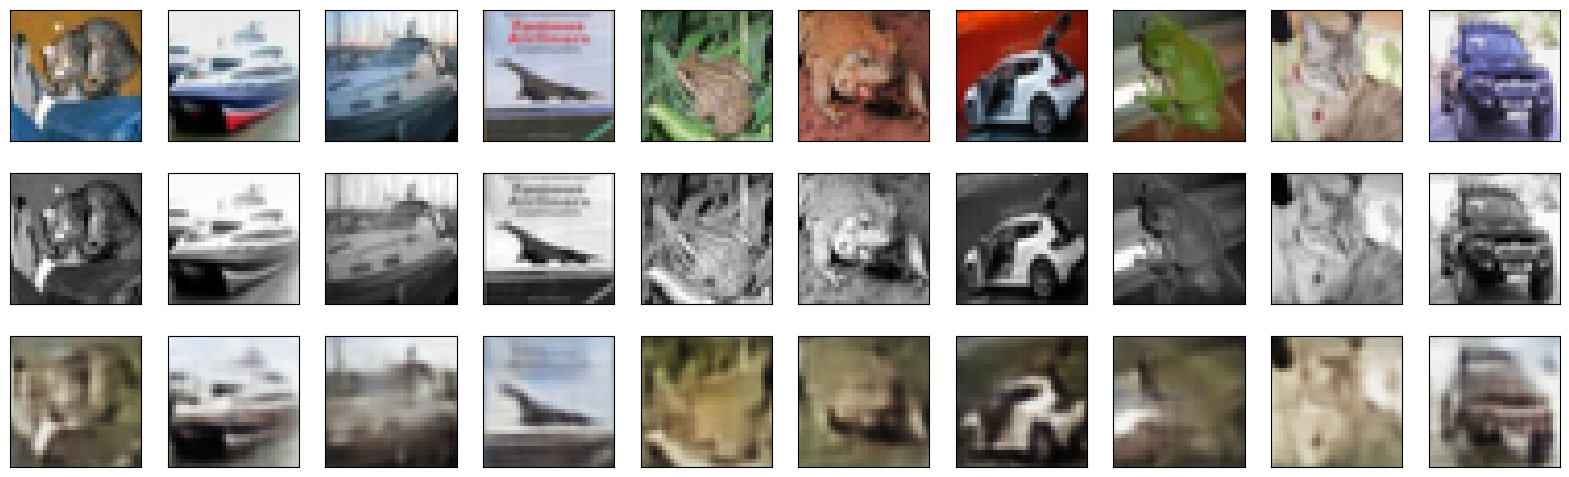

In [ ]:
# Predict colorization
decoded_imgs = autoencoder.predict(x_test_gray)

# Display original, grayscale, and colorized images
n = 10  # Number of images to display
plt.figure(figsize=(20, 6))
for i in range(n):
    # Original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Grayscale
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_gray[i].reshape(32, 32), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Colorized
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Colorize an External Image with image size like CFAR10 Dataset

In [ ]:
def colorize_image(image_path, model):
    # Load the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (32, 32))
    img = img.astype('float32') / 255.
    img = img.reshape(1, 32, 32, 1)

    # Predict the colorization
    predicted_img = model.predict(img)
    predicted_img = predicted_img.reshape(32, 32, 3)

    # Display the grayscale and colorized images
    plt.figure(figsize=(10, 5))

    # Grayscale
    ax = plt.subplot(1, 2, 1)
    plt.imshow(img.reshape(32, 32), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Grayscale')

    # Colorized
    ax = plt.subplot(1, 2, 2)
    plt.imshow(predicted_img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Colorized')

    plt.show()

1/1 [==============================] - 0s 28ms/step


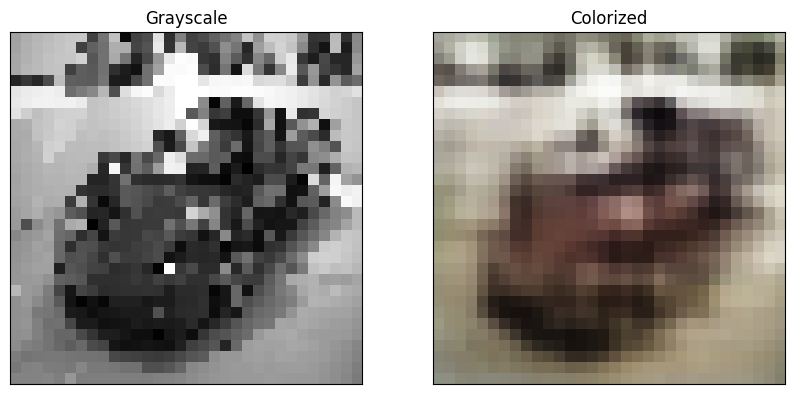

In [ ]:
# Example usage
colorize_image('/content/drive/MyDrive/LaFerrari_in_Beverly_Hills_(14563979888).jpg', autoencoder)

## Import Driver

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Save the model

In [ ]:
autoencoder.save('/content/drive/MyDrive/'+'AE_CFAR10.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Load Model and Remove Input Layer to get any image with any size

In [6]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input

# Load the trained model
autoencoder = load_model('/content/drive/MyDrive/'+'AE_CFAR10.h5')

# Create a new model with variable input size
input_img_var = Input(shape=(None, None, 1))  # Variable input size

# Recreate the layers from the trained model
x = autoencoder.layers[1](input_img_var)
for layer in autoencoder.layers[2:]:
    x = layer(x)

autoencoder_var = Model(inputs=input_img_var, outputs=x)

In [18]:
autoencoder_var.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d (Conv2D)             multiple                  320       
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           multiple                  18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           multiple                  73856 

In [16]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
def colorize_image(image_path, model):
    # Load and preprocess the image
    img = cv2.imread(image_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = img_gray.astype('float32') / 255.
    img_gray = np.expand_dims(img_gray, axis=-1)  # Add channel dimension
    img_gray = np.expand_dims(img_gray, axis=0)  # Add batch dimension

    # Predict the colorized image
    img_color = model.predict(img_gray)
    img_color = img_color[0]  # Remove batch dimension
    img_color = np.clip(img_color, 0, 1) * 255
    img_color = img_color.astype('uint8')

    # Display the grayscale and colorized images side by side
    plt.figure(figsize=(10, 5))

    # Grayscale
    ax = plt.subplot(1, 2, 1)
    plt.imshow(img_gray[0, :, :, 0], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Grayscale')

    # Colorized
    ax = plt.subplot(1, 2, 2)
    plt.imshow(img_color)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Colorized')

    plt.show()

1/1 [==============================] - 1s 1s/step


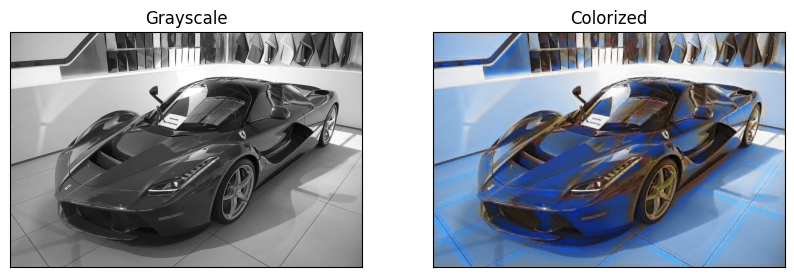

In [17]:
# Example usage
colorize_image('/content/drive/MyDrive/LaFerrari_in_Beverly_Hills_(14563979888).jpg', autoencoder_var)